# Lyft LVT Homework








## Ruhan Dong, applicant for data analyst intern

## Question 1 : What are the main factors that affect a driver’s lifetime value?

### For a consumer-facing business, like Lyft, lifetime value is a very important concept. Usually, it is caculated as:    ### Life time value = Gross Contribution / (1+d-r)
### Thus, since d is the discounted cash rate (assign it as 0.55%), which is fixed in the market. Gross contribution and retention rate (1-churn rate) are the most important two factors.
### In this case, gross contribution is 1.75 (Service Fee) * average number of total rides during the three months per driver. Churn rate can be caculated under the assumption that drivers who did not take any ride through the last two week before recording day in the dataset.

### Gross Contribution = 1.75*220 = 385
### r = retention rate = 589 / 837 = 70.37%
### Life time value = 385 / (1+ 0.55%-70.37%) = 1328 US Dollar

#### * All numbers will be denoted in the later caculation.

## Question 2 : What is the average projected lifetime of a driver? That is, once a driver is onboarded, how long does he/she typically continue driving with Lyft.

### This number shall be caculated as, 1/ monthly churn rate 
### To simplify the question, let us assume the churn rate growth follow the simple growth rule, thus, the monthly churn rate = (1-70.37%)/3 = 10%
### The typical life time of a driver is 1/10% = 10 months

## Question 3 : Explore how drivers churn once they start driving with Lyft. Are there any predictiveindicators for driver churn?
### To answer this question, I need to do more data exploratory analysis and build a model on it. 

## 3.1 Data Cleaning

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
%matplotlib inline

In [2]:
driver_ids = pd.read_csv('driver_ids.csv')
ride_ids = pd.read_csv('ride_ids.csv')
ride_timestamps = pd.read_csv('ride_timestamps.csv')

In [3]:
df = driver_ids.merge(ride_ids, how='inner', on="driver_id")
#only select 'drop off'
ride_timestamps_new = ride_timestamps[ride_timestamps["event"] == "dropped_off_at"]
df = df.merge(ride_timestamps_new,how='inner', on="ride_id")

#After merge, there are total of 837 effective drivers.

In [4]:
df.describe()

,ride_distance,ride_duration,ride_prime_time
count,184209.000000,184209.000000,184209.000000
mean,6945.197042,859.872292,17.373880
std,8938.015943,572.846146,30.833558
min,-2.000000,2.000000,0.000000
25%,2457.000000,492.000000,0.000000
50%,4007.000000,727.000000,0.000000
75%,7169.000000,1070.000000,25.000000
max,724679.000000,28204.000000,500.000000


## 3.2 Exploratory Analysis

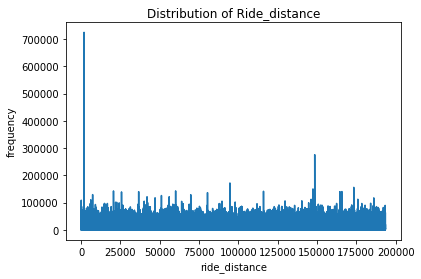

In [5]:
#Distribution of ride distance
y_axis = ride_ids['ride_distance']
plt.plot(y_axis)
plt.ylabel('frequency')
plt.xlabel('ride_distance')
plt.title('Distribution of Ride_distance')
plt.show()

#Interesting facts: short distance trip dominants the dataset

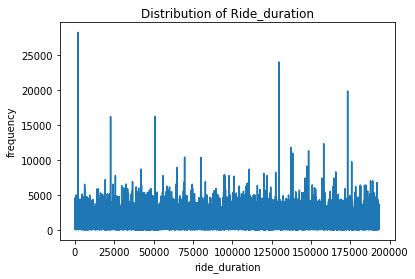

In [6]:
#Distribution of ride distance
y_axis = ride_ids['ride_duration']
plt.plot(y_axis)
plt.ylabel('frequency')
plt.xlabel('ride_duration')
plt.title('Distribution of Ride_duration')
plt.show()

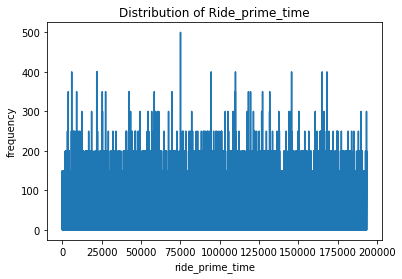

In [7]:
#Distribution of ride_prime_time
y_axis = ride_ids['ride_prime_time']
plt.plot(y_axis)
plt.ylabel('frequency')
plt.xlabel('ride_prime_time')
plt.title('Distribution of Ride_prime_time')
plt.show()

## 3.3 Feature Engineering 

In [8]:
df.columns

Index(['driver_id', 'driver_onboard_date', 'ride_id', 'ride_distance',
       'ride_duration', 'ride_prime_time', 'event', 'timestamp'],
      dtype='object')

In [9]:
#calculate driver's income per ride
def calculate_fare(x):
    fare = 2 + x[0]*1.15/1609.34 + x[1]*0.22/60
    if fare <= 5:
        return 5
    elif fare>=400:
        return 400
    else:
        return fare
df['fare']= df[['ride_distance', 'ride_duration']].apply(calculate_fare, axis=1)

In [10]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['dayofweek'] = df['timestamp'].apply(lambda x: x.dayofweek)
df['hour'] = df['timestamp'].apply(lambda x: x.hour)
df['dayofyear'] = df['timestamp'].apply(lambda x: x.dayofyear)

In [11]:
def get_agg(df,col):
    new_df = df.groupby('driver_id')[col].agg(['min', 'max','sum','mean','median']).reset_index()
    new_df.columns = ['driver_id',col + '_min',col + '_max',col + '_sum',col + '_mean',col + '_median']
    return new_df

In [12]:
ride_distance_details = get_agg(df,'ride_distance')
ride_duration_details = get_agg(df,'ride_duration')
ride_prime_time_details = get_agg(df,'ride_prime_time')
fare_details= get_agg(df,'fare')
agg_df = ride_distance_details.merge(ride_duration_details,on='driver_id').merge(ride_prime_time_details,on='driver_id').merge(fare_details,on='driver_id')

In [13]:
#add ride_count
ride_count = df.groupby('driver_id')['ride_distance'].agg(['count']).reset_index()
ride_count.columns = ['driver_id','ride_count']
agg_df = agg_df.merge(ride_count,on='driver_id')

In [14]:
# Caculate the days interval of the last driving day of a driver and last recording day in the dataset
time_maxmin = df.groupby('driver_id')['timestamp'].agg(['max','min']).reset_index()
time_maxmin.columns  = ['driver_id','max_active_time','min_active_time']
agg_df = agg_df.merge(time_maxmin,on='driver_id')

agg_df['time_diff'] = agg_df['max_active_time'].max() - agg_df['max_active_time']
agg_df['time_diff'] = agg_df['time_diff'].apply(lambda x: x.days)

In [15]:
# Define churn drivers as drivers who did not take any ride through the last two week before the 
# last recording day in the dataset
agg_df['churn'] = agg_df['time_diff'].apply(lambda x: 1 if x>14 else 0)

In [16]:
#New feature-whether a dirver is a full time driver (Defined as: the driver who finished orders more than 45 out of 90
# days in the dataset)
unique_day = df.groupby('driver_id').agg({"dayofyear":lambda x: x.nunique()})
unique_day['if_fulltime'] = unique_day['dayofyear'].apply(lambda x: 1 if x>45 else 0)
unique_day = unique_day.reset_index()
unique_day.columns = ['driver_id','unique_day','if_fulltime']
agg_df = agg_df.merge(unique_day,on='driver_id')

In [17]:
#New feature-whether a dirver is a weekend driver (Defined as: if the driver drives on weekend)
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if x>4 else 0) 
weekend= df.groupby('driver_id')['weekend'].agg(np.sum).reset_index()
weekend.columns = ['driver_id','weekend_count']
agg_df = agg_df.merge(weekend,on='driver_id')
agg_df['weekend_driver'] = agg_df[['weekend_count','ride_count']].apply(lambda x: 1 if x[0]/x[1] > 0.5 else 0, axis =1)

In [18]:
#New feature-whether a dirver is a weekend driver (Defined as: if the driver drives through 19:00 to 7:00)
df['if_night'] = df['hour'].apply(lambda x: 1 if x<=7 else (1 if x>=19 else 0))
night= df.groupby('driver_id')['if_night'].agg(np.sum).reset_index()
night.columns = ['driver_id','night_count']
agg_df = agg_df.merge(night,on='driver_id')
agg_df['night_driver'] = agg_df[['night_count','ride_count']].apply(lambda x: 1 if x[0]/x[1] > 0.5 else 0, axis =1)

In [19]:
#New feature-whether the drive spends a large time （more than 16）on prime times
#prime_time chaser driver
#agg_df.describe().iloc[:,10:20]
agg_df['if_prime'] = agg_df['ride_prime_time_mean'].apply(lambda x: 1 if x>16 else 0)

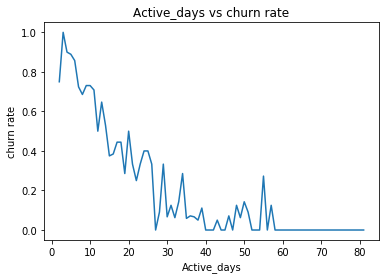

In [20]:
#Preliminary exploration of the relationship between Active_days and churn rate 
unique_churn = agg_df[['unique_day','churn']].groupby('unique_day').agg(['count','sum']).reset_index()
x_axis = unique_churn['unique_day']
y_axis = unique_churn['churn']["sum"] / unique_churn['churn']["count"] 

plt.plot(x_axis,y_axis)
plt.ylabel('churn rate')
plt.xlabel('Active_days')
plt.title('Active_days vs churn rate')
plt.show()

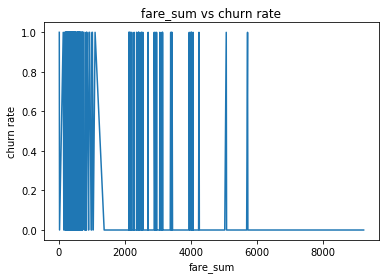

In [21]:
#Preliminary exploration of the relationship between total fares earned and churn rate
unique_churn = agg_df[['fare_sum','churn']].groupby('fare_sum').agg(['count','sum']).reset_index()
x_axis = unique_churn['fare_sum']
y_axis = unique_churn['churn']["sum"] / unique_churn['churn']["count"] 

plt.plot(x_axis,y_axis)
plt.ylabel('churn rate')
plt.xlabel('fare_sum')
plt.title('fare_sum vs churn rate')
plt.show()

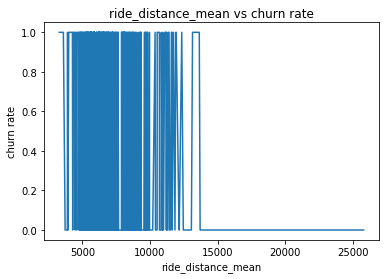

In [22]:
#Preliminary exploration of the relationship between average ride distance and churn rate
unique_churn = agg_df[['ride_distance_mean','churn']].groupby('ride_distance_mean').agg(['count','sum']).reset_index()
x_axis = unique_churn['ride_distance_mean']
y_axis = unique_churn['churn']["sum"] / unique_churn['churn']["count"] 

plt.plot(x_axis,y_axis)
plt.ylabel('churn rate')
plt.xlabel('ride_distance_mean')
plt.title('ride_distance_mean vs churn rate')
plt.show()



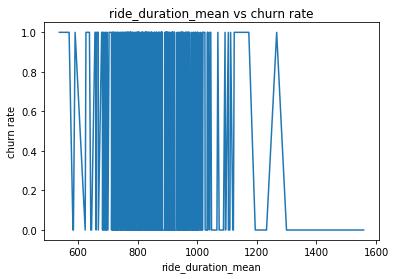

In [23]:
#Preliminary exploration of the relationship between average ride duration and churn rate
unique_churn = agg_df[['ride_duration_mean','churn']].groupby('ride_duration_mean').agg(['count','sum']).reset_index()
x_axis = unique_churn['ride_duration_mean']
y_axis = unique_churn['churn']["sum"] / unique_churn['churn']["count"] 

plt.plot(x_axis,y_axis)
plt.ylabel('churn rate')
plt.xlabel('ride_duration_mean')
plt.title('ride_duration_mean vs churn rate')
plt.show()



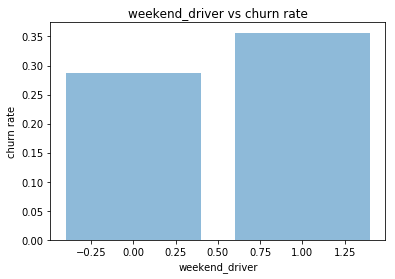

In [24]:
# Preliminary exploration of the relationship between whether a driver is a weekend driver and churn rate
unique_churn = agg_df[['weekend_driver','churn']].groupby('weekend_driver').agg(['count','sum']).reset_index()
x_axis = unique_churn['weekend_driver']
y_axis = unique_churn['churn']["sum"] / unique_churn['churn']["count"] 

plt.bar(x_axis,y_axis,align='center', alpha=0.5)
plt.ylabel('churn rate')
plt.xlabel('weekend_driver')
plt.title('weekend_driver vs churn rate')
plt.show()

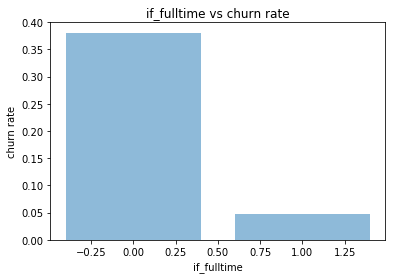

In [25]:
# Preliminary exploration of the relationship between whether a driver is a full-time driver and churn rate
unique_churn = agg_df[['if_fulltime','churn']].groupby('if_fulltime').agg(['count','sum']).reset_index()
x_axis = unique_churn['if_fulltime']
y_axis = unique_churn['churn']["sum"] / unique_churn['churn']["count"] 

plt.bar(x_axis,y_axis,align='center', alpha=0.5)
plt.ylabel('churn rate')
plt.xlabel('if_fulltime')
plt.title('if_fulltime vs churn rate')
plt.show()

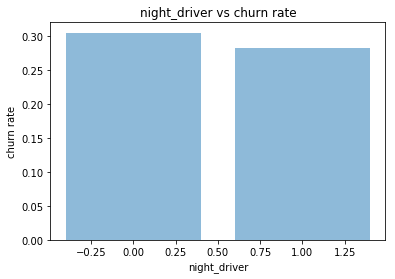

In [26]:
# Preliminary exploration of the relationship between whether a driver is a night_driver and churn rate
unique_churn = agg_df[['night_driver','churn']].groupby('night_driver').agg(['count','sum']).reset_index()
x_axis = unique_churn['night_driver']
y_axis = unique_churn['churn']["sum"] / unique_churn['churn']["count"] 

plt.bar(x_axis,y_axis,align='center', alpha=0.5)
plt.ylabel('churn rate')
plt.xlabel('night_driver')
plt.title('night_driver vs churn rate')
plt.show()

## 3.4 Modeling

### I choose random forest in this case because can handle outliers, irrelevant variables, continuous and discrete variables and runs very fast. Meanwhile it is very helpful to have the feature importance rank from random forest model.


In [27]:
agg_df.columns

Index(['driver_id', 'ride_distance_min', 'ride_distance_max',
       'ride_distance_sum', 'ride_distance_mean', 'ride_distance_median',
       'ride_duration_min', 'ride_duration_max', 'ride_duration_sum',
       'ride_duration_mean', 'ride_duration_median', 'ride_prime_time_min',
       'ride_prime_time_max', 'ride_prime_time_sum', 'ride_prime_time_mean',
       'ride_prime_time_median', 'fare_min', 'fare_max', 'fare_sum',
       'fare_mean', 'fare_median', 'ride_count', 'max_active_time',
       'min_active_time', 'time_diff', 'churn', 'unique_day', 'if_fulltime',
       'weekend_count', 'weekend_driver', 'night_count', 'night_driver',
       'if_prime'],
      dtype='object')

In [28]:
drop_column = ['driver_id','time_diff','max_active_time', 'min_active_time','night_count','weekend_count']

In [29]:
dataset = agg_df.drop(drop_column,axis=1)

In [30]:
X = dataset.drop(['churn'],axis=1)
y = dataset['churn']

In [31]:
(X.shape, y.shape)

((837, 26), (837,))

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
rf = RandomForestClassifier(n_estimators=1000, max_features = 5, n_jobs=2, random_state=42)
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=5, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=2, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [33]:
y_pred = rf.predict(X_test)

In [34]:
from sklearn import metrics
print (metrics.classification_report(y_test, y_pred ))# accuracy

             precision    recall  f1-score   support

          0       0.89      0.88      0.89       198
          1       0.71      0.72      0.72        79

avg / total       0.84      0.84      0.84       277



In [35]:
feature_importances = list(zip(X.columns, rf.feature_importances_))
feature_importances = sorted(feature_importances, key=lambda x: x[1],reverse=True)
feature_importances

[('unique_day', 0.10777188120843199),
 ('fare_sum', 0.092332103382460354),
 ('ride_distance_sum', 0.091941430657180537),
 ('ride_duration_sum', 0.083400570867959489),
 ('ride_count', 0.072769209648142305),
 ('ride_prime_time_sum', 0.072015440406559661),
 ('ride_distance_min', 0.047016796952261679),
 ('fare_max', 0.04186926210881492),
 ('ride_duration_max', 0.04127723493207875),
 ('ride_distance_max', 0.039916242079875146),
 ('ride_duration_min', 0.039438150147645276),
 ('ride_duration_mean', 0.037208896127169072),
 ('ride_duration_median', 0.035028351492567507),
 ('ride_distance_median', 0.033216670698714604),
 ('ride_distance_mean', 0.031219796190597685),
 ('fare_mean', 0.030946668636002168),
 ('ride_prime_time_mean', 0.030944633719614943),
 ('fare_median', 0.028153475299487279),
 ('ride_prime_time_max', 0.02572222872950335),
 ('weekend_driver', 0.0051917542432180722),
 ('night_driver', 0.0042619516778050802),
 ('if_prime', 0.0031067136556773949),
 ('if_fulltime', 0.002518857510132971

## Question 4 : Do all drivers act alike? Are there specific segments of drivers that generate more value for Lyft than the average driver?

### ( Due to time limit, for this question, I did not use python to solve this problem. Instead, I used Tableau to simulate different segmentations and compared the results to come up with the answer below. I have attched the simulated results on the PPT slide and would definitely like to talk more about my ideas for the presentation.)


### Drivers act very different. According to their driving behavors, the best way I came out was to segment them into three segments: 
### Segment A: full-time driver
### Segment B: prime chaser driver (Drive occasionaly) 
### Segement C: weekend driver (Drive mostly on weekends)
### Segment A is the best segment that generate more value than the average driver, the number was 1.6 times the prime chaser driver and tripled the weekend driver.

## Question 5 : What relevant business uses does this metric have?

### 1. This metric helps Lyft focus on “the most-valued” drivers.
### Full-time drivers drive the value for the platform most and are the most sustainable ones. The platform should keep keep in mind of their interest (Most likely, they are looking for a stable way to make money for life under this segment.) to make the platform grow the best.
### 2. This metric helps Lyft to release driver incentive plan to help new registered driver retain.
### This it to help new drivers cross the bottleneck and stay. Once they stay, they can live with the current ecosystem to make money.
### 3. This metric helps Lyft revaluate the driver acquisition cost.
### When the driver acquisition cost is higher than the life time value of the driver, there is no need to acquire them anymore. It is only necessary when the the driver acquisition cost is lower than the life time value of the driver.



